# MLEnd Hums and Whistles II - Starter kit

The objective of this notebook is to provide you a small sample and starter code, that will help you to start thinking about your Mini-Project. In this notebook, you will download a small sample, extract a few features, train a model and test it's performance.


Let's start by loading a few useful Python libraries.

## Environment set-up

To set-up the environment, you need to download the dataset and make sure you have required libraries installed.

In [1]:
# !pip install librosa --quiet
# !pip install spkit --quiet
# !pip install -U scikit-learn --quiet

In [5]:
!pip install librosa
!pip install spkit

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import math

import IPython.display as ipd
from tqdm import tqdm
import spkit as sp
import librosa

# Data download

In this section we will download a small subsample of the MLEnd Hums and Whistles Dataset.

You should be able to download the entire training dataset using a similar approach to the one used here for the subsample. As you will see, you only need to provide a different link.

You can also use the following link to download download the file 'MLEndHW_Sample.zip':

#### [MLEndHW_Sample.zip](https://github.com/thekmannn/MLEndHW_Sample/raw/main/MLEndHW_Sample.zip)

Please note that even though we call it "training" dataset you can do whatever you want with it (for instance validate a set of models). We have kept a separate dataset for testing purposes, which we won't share with anyone.

First, let's define a function that will allow us to download a file into a chosen location.

In [3]:
def download_url(url, save_path):
    # 定义一个函数：把指定 url 的文件流式下载到本地 save_path，并带进度条。
    # 标准格式：def 函数名(参数1, 参数2, ...): -> 返回值（可选）
    # 用法：download_url("https://xxx/file.zip", "本地路径/file.zip")

    with urllib.request.urlopen(url) as dl_file:
        # 用 urllib 打开远程 URL，返回一个类文件对象 dl_file，支持 read()。
        # 标准格式：urllib.request.urlopen(url, timeout=...) -> HTTPResponse 对象
        # 使用 with 语法保证连接自动关闭。

        total_size = int(dl_file.getheader('Content-Length', 0))
        # 从 HTTP 响应头里取出文件总字节数，若服务器没返回则默认为 0。
        # 标准格式：response.getheader(name, default=None)

        block_size = 8192
        # 每次读 8 KiB（8192 字节）到内存，平衡速度与内存占用。
        # 可任意调整，常见 4096 / 8192 / 16384。

        with open(save_path, 'wb') as out_file, tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
            # 同时打开两个上下文管理器：
            # 1. 以二进制写模式打开本地文件，准备写入。
            #    标准格式：open(file, mode='wb') -> file object
            # 2. 实例化 tqdm 进度条，总刻度为文件大小，单位 B，自动换算 KB/MB，前缀“Downloading”。
            #    标准格式：tqdm(iterable=None, total=?, unit=?, unit_scale=?, desc=?)

            while True:
                # 无限循环，直到把文件读完。

                data = dl_file.read(block_size)
                # 从远程连接读取最多 block_size 字节，返回 bytes 对象。
                # 读到 EOF 时返回 b''。

                if not data:
                    # 如果本次没读到数据，说明已到达文件末尾。
                    break
                    # 跳出循环，结束下载。

                out_file.write(data)
                # 把刚读到的字节块写入本地文件。

                pbar.update(len(data))
                # 把本次写入的字节数更新到 tqdm 进度条，UI 会实时滚动。
                # 标准格式：tqdm.update(n)  # n 为增量

The next step is to download the file 'MLEndHW_Sample.zip' into the folder 'MyDrive/Data/MLEndHW'. Note that this might take a while!

In [4]:
url = "https://github.com/thekmannn/MLEndHW_Sample/raw/main/MLEndHW_Sample.zip"
# 定义待下载文件的远程地址（GitHub Raw 直链）。
# 标准格式：字符串，http/https 开头，末尾允许带参数或 token。

save_path = 'Data/MLEndHW/MLEndHW_Sample.zip'
# 定义文件保存到本地的相对路径。
# 标准格式：字符串，支持相对路径（相对于 os.getcwd()）或绝对路径。
# 路径分隔符：Windows 可用 "\\" 或 r"\"，Unix 用 "/"；Python 3 统一支持 "/"。

os.makedirs(os.path.dirname(save_path), exist_ok=True)
# 确保上级目录存在，若不存在则递归创建；已存在时不报错。
# 标准格式：os.makedirs(path, mode=0o777, exist_ok=False)
# os.path.dirname(path) 返回去掉最后一级文件名后的目录路径。

download_url(url, save_path)
# 调用自定义函数，把 url 指向的文件流式下载到 save_path，并显示进度条。
# 函数签名：def download_url(url: str, save_path: str) -> None

Downloading: 100%|██████████| 167M/167M [00:00<00:00, 334MB/s] 


Run the following cell to check that the MLEndHW folder contains the file 'MLEndHW_Sample.zip':

In [5]:
path = 'Data/MLEndHW'
# 声明要查看的目录路径（相对路径，基准为当前 Jupyter/脚本所在工作目录）。
# 标准格式：字符串，可相对可绝对；推荐用原始字符串 r"..." 避免转义问题。

os.listdir(path)
# 列出该目录下所有**直接子级**文件和文件夹的名字，返回一个字符串列表。
# 标准格式：os.listdir(path='.') -> List[str]
# 注意：
#   - 不递归子目录；
#   - 顺序任意；
#   - 若路径不存在会抛 FileNotFoundError。
# 典型后续用法：
#   files = [f for f in os.listdir(path) if f.endswith('.wav')]

['MLEndHW_Sample.zip']

# Understanding our dataset sample

Let's unzip the sample data and now check how many audio files we have:

In [6]:
directory_to_extract_to = 'Data/MLEndHW/sample/'
# 设定解压后文件要放的目录（末尾带 "/" 更清晰，但 Python 不强制）。
# 标准格式：字符串，绝对或相对路径均可。

os.makedirs(os.path.dirname(directory_to_extract_to), exist_ok=True)
# 确保上述目录的父级存在；若已存在也不报错。
# 注意：os.path.dirname('Data/MLEndHW/sample/') 返回 'Data/MLEndHW'，
# 所以这句等价于确保 'Data/MLEndHW' 存在。
# 标准格式：os.makedirs(path, mode=0o777, exist_ok=False)

zip_path = 'Data/MLEndHW/MLEndHW_Sample.zip'
# 指定待解压的 zip 文件路径（前面下载得到的）。

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # 以只读模式打开 zip 文件，返回 ZipFile 对象 zip_ref；
    # 使用 with 语句保证文件句柄自动关闭。
    # 标准格式：zipfile.ZipFile(file, mode='r', compression=ZIP_STORED, ...)

    zip_ref.extractall(directory_to_extract_to)
    # 将压缩包内所有成员解压到 directory_to_extract_to 目录。
    # 标准格式：ZipFile.extractall(path=None, members=None, pwd=None)

sample_path = 'Data/MLEndHW/sample/MLEndHW_Sample/*.wav'
# 构造通配符模式，准备匹配解压后子目录里所有 wav 文件。
# glob 模式规则：* 匹配任意长度字符，? 匹配单个字符，** 可递归（需 recursive=True）。

files = glob.glob(sample_path)
# 返回符合模式的文件路径列表（相对路径），无文件则为空列表。
# 标准格式：glob.glob(pathname, *, recursive=False) -> List[str]

len(files)
# 查看成功匹配到的 wav 文件数量，验证解压及路径是否正确。

98

This figure (98) corresponds to the number of **items** or **samples** in our dataset. Let's listen to some random audio files:

In [ ]:
for _ in range(5):
    # 下划线惯例表示“循环变量不会被使用”，纯粹想重复 5 次。
    # 标准格式：for 变量 in iterable:

    n = np.random.randint(98)
    # 从 [0, 98) 均匀随机取一个整数，作为后续要播放的音频下标。
    # 要求：numpy 已导入为 np；上界 98 需 ≤ len(files) 否则会索引越界。
    # 标准格式：np.random.randint(low, high=None, size=None, dtype=int)

    display(ipd.Audio(files[n]))
    # 把第 n 个 wav 文件加载成 HTML5 音频控件并直接在 Notebook 单元格内播放。
    # 标准格式：IPython.display.Audio(filename 或 data, autoplay=False)
    # 注意：files[n] 必须是完整路径字符串或字节数据；display() 需 IPython.display 已导入为 ipd。

Can you recognise each song? Can you tell whether the interpreters are humming or whistling to the song?

Let's have a look at the name of the 98 audio file:

In [7]:
for file in files:
    # 遍历前面 glob 得到的 wav 路径列表，每次循环把单个路径字符串赋给 file。
    # 标准格式：for 变量 in 可迭代对象:

    print(
        file.replace("\\", "/")          # 把 Windows 反斜杠统一换成正斜杠，防止分隔符混乱。
        .split(r'/')[-1]                 # 按正斜杠切分成列表，取最后一项（即纯文件名，含扩展名）。
    )
    # 整行作用：只保留路径最后的文件名并打印，方便快速查看样本名称。
    # 等价写法：os.path.basename(file)
    # 标准用法示例：
    #   path = "Data/MLEndHW/sample/MLEndHW_Sample/001.wav"
    #   print(os.path.basename(path))  # -> 001.wav

S32_whistle_2_Rain.wav
S24_hum_1_Rain.wav
S2_hum_1_Rain.wav
S4_hum_2_Hakuna.wav
S1_whistle_1_StarWars.wav
S3_whistle_1_Panther.wav
S34_whistle_2_Hakuna.wav
S1_whistle_2_Potter.wav
S32_hum_1_Rain.wav
S7_hum_2_Hakuna.wav
S16_hum_2_Hakuna.wav
S2_whistle_1_StarWars.wav
S24_hum_2_Mamma.wav
S1_hum_1_Rain.wav
S32_hum_1_Showman.wav
S15_whistle_1_Panther.wav
S34_whistle_2_Mamma.wav
S6_whistle_2_Potter.wav
S6_whistle_1_Mamma.wav
S32_whistle_2_Hakuna.wav
S1_hum_2_Hakuna.wav
S7_hum_4_Panther.wav
S29_hum_1_Showman.wav
S4_hum_2_Frozen.wav
S6_hum_2_Mamma.wav
S1_hum_1_StarWars.wav
S4_hum_4_Showman.wav
S1_whistle_2_Rain.wav
S2_hum_1_StarWars.wav
S24_whistle_1_StarWars.wav
S2_hum_1_Showman.wav
S1_whistle_2_Mamma.wav
S16_hum_1_StarWars.wav
S2_whistle_2_Frozen.wav
S15_hum_1_Rain.wav
S15_hum_2_Potter.wav
S24_hum_2_Potter.wav
S24_whistle_1_Panther.wav
S16_hum_1_Rain.wav
S1_hum_1_Showman.wav
S15_hum_1_StarWars.wav
S2_whistle_2_Rain.wav
S2_hum_2_Panther.wav
S2_whistle_2_Showman.wav
S24_hum_2_Panther.wav
S24_w

As you can see, the name of each file follows the naming convention `[Participant ID]_[type of recording]_[interpretation number]_[song]`. We can parse each file name and extract this information. Let's do it for the first one:

In [33]:
print('The full path to the first audio file is: ', files[0])
# 打印列表里第 1 个 wav 文件的完整（相对）路径，方便确认位置。
# 标准格式：print(*objects, sep=' ', end='\n')

print('\n')
# 输出一个空行，仅用于美化排版。\n 代表换行符。

print('The name of the first audio file is: ',
      files[0].replace("\\", "/").split('/')[-1])
# 把路径里的反斜杠换成正斜杠后，按 / 切分并取最后一段 -> 纯文件名。
# 等价于 os.path.basename(files[0])

print('    The participand ID is: ',
      files[0].replace("\\", "/").split('/')[-1].split('_')[0])
# 假设文件名形如：P01_Task_03_Song.wav
# 用下划线切分后第 0 段即为参与者编号。

print('    The type of interpretation is: ',
      files[0].replace("\\", "/").split('/')[-1].split('_')[1])
# 第 1 段对应解释/任务类型。

print('    The interpretation number is: ',
      files[0].replace("\\", "/").split('/')[-1].split('_')[2])
# 第 2 段对应解释序号。

print('    The song is: ',
      files[0].replace("\\", "/").split('/')[-1].split('_')[3])
# 第 3 段对应歌曲名（含扩展名 .wav，如需去掉可再 .split('.')[0]）。

The full path to the first audio file is:  Data/MLEndHW/sample/MLEndHW_Sample/S32_whistle_2_Rain.wav


The name of the first audio file is:  S32_whistle_2_Rain.wav
    The participand ID is:  S32
    The type of interpretation is:  whistle
    The interpretation number is:  2
    The song is:  Rain.wav


We can create a table-like structure using Python lists that collects the information that we can extract from the names of the audio files:

In [34]:
MLENDHW_table = []
# 初始化一个空列表，用来存放后面每一行提取出的元数据。
# 最终会变成二维列表，可直接转 DataFrame。

for file in files:
    # 遍历所有 wav 文件路径，依次处理。

    file_name = file.replace("\\", "/").split('/')[-1]
    # 把路径里的反斜杠统一换成正斜杠后，取最后一段 -> 纯文件名。
    # 等价于 os.path.basename(file)

    participant_ID = file.replace("\\", "/").split('/')[-1].split('_')[0]
    # 按下划线切分文件名，第 0 段是参与者编号，例如 P01。

    interpretation_type = file.replace("\\", "/").split('/')[-1].split('_')[1]
    # 第 1 段是解释/任务类型，例如 Task。

    interpretation_number = file.replace("\\", "/").split('/')[-1].split('_')[2]
    # 第 2 段是解释序号，例如 03。

    song = file.replace("\\", "/").split('/')[-1].split('_')[3].split('.')[0]
    # 第 3 段是歌曲名+扩展名，再按点切分取第 0 段即可去掉 .wav。
    # 例如 Song.wav -> Song

    MLENDHW_table.append([file_name, participant_ID, interpretation_type,
                          interpretation_number, song])
    # 把当前文件提取出的 5 个字段作为一行追加到列表。
    # 标准格式：list.append(element)

MLENDHW_table
# 在 Notebook 里最后一行无需 print，直接回显二维列表内容，方便检查。

[['S32_whistle_2_Rain.wav', 'S32', 'whistle', '2', 'Rain'],
 ['S24_hum_1_Rain.wav', 'S24', 'hum', '1', 'Rain'],
 ['S2_hum_1_Rain.wav', 'S2', 'hum', '1', 'Rain'],
 ['S4_hum_2_Hakuna.wav', 'S4', 'hum', '2', 'Hakuna'],
 ['S1_whistle_1_StarWars.wav', 'S1', 'whistle', '1', 'StarWars'],
 ['S3_whistle_1_Panther.wav', 'S3', 'whistle', '1', 'Panther'],
 ['S34_whistle_2_Hakuna.wav', 'S34', 'whistle', '2', 'Hakuna'],
 ['S1_whistle_2_Potter.wav', 'S1', 'whistle', '2', 'Potter'],
 ['S32_hum_1_Rain.wav', 'S32', 'hum', '1', 'Rain'],
 ['S7_hum_2_Hakuna.wav', 'S7', 'hum', '2', 'Hakuna'],
 ['S16_hum_2_Hakuna.wav', 'S16', 'hum', '2', 'Hakuna'],
 ['S2_whistle_1_StarWars.wav', 'S2', 'whistle', '1', 'StarWars'],
 ['S24_hum_2_Mamma.wav', 'S24', 'hum', '2', 'Mamma'],
 ['S1_hum_1_Rain.wav', 'S1', 'hum', '1', 'Rain'],
 ['S32_hum_1_Showman.wav', 'S32', 'hum', '1', 'Showman'],
 ['S15_whistle_1_Panther.wav', 'S15', 'whistle', '1', 'Panther'],
 ['S34_whistle_2_Mamma.wav', 'S34', 'whistle', '2', 'Mamma'],
 ['S6_whis

We can load the table into a Pandas DataFrame and usie the additional functionalities of Pandas to explore the information extracted from the names of the audio files.

In [35]:
MLENDHW_df = pd.DataFrame(
    MLENDHW_table,                       # 二维列表 → 数据本体
    columns=['file_id','participant','interpretation','number','song']  # 指定列名
).set_index('file_id')                 # 把列 file_id 设为行索引，不再占用普通列

# 标准格式：
# pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
# DataFrame.set_index(keys, drop=True, append=False, inplace=False)

MLENDHW_df                              # 在 Notebook 中回显结果，快速预览

participant interpretation number      song
file_id                                                              
S32_whistle_2_Rain.wav            S32        whistle      2      Rain
S24_hum_1_Rain.wav                S24            hum      1      Rain
S2_hum_1_Rain.wav                  S2            hum      1      Rain
S4_hum_2_Hakuna.wav                S4            hum      2    Hakuna
S1_whistle_1_StarWars.wav          S1        whistle      1  StarWars
...                               ...            ...    ...       ...
S29_hum_1_StarWars.wav            S29            hum      1  StarWars
S29_whistle_2_Showman.wav         S29        whistle      2   Showman
S15_whistle_2_Showman.wav         S15        whistle      2   Showman
S16_whistle_2_Rain.wav            S16        whistle      2      Rain
S2_hum_2_Potter.wav                S2            hum      2    Potter

[98 rows x 4 columns]


Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D temporal grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance, a sampling frequency of 5Hz indicates that 5 samples are produced per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

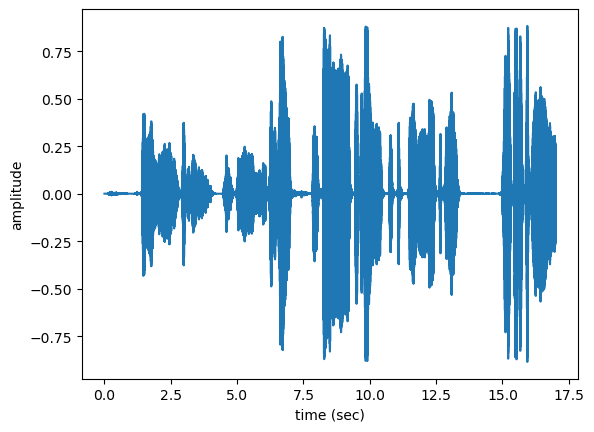

In [36]:
n = 0
# 选择文件列表里的第 1 条音频（下标从 0 开始），后面用它做示例。

fs = None
# 预声明采样率变量；None 表示“交给 librosa 决定”，librosa 默认会重采样到 22 050 Hz。
# 若给具体值（如 16 000），则 librosa 会强制重采样到该值。

x, fs = librosa.load(files[n], sr=fs)
# 加载音频：返回
#   x     – 一维 numpy 数组，归一化到 [-1, 1] 的浮点波形；
#   fs    – 实际采样率（Hz）。
# 标准格式：librosa.load(path, sr=22050, mono=True, offset=0.0, duration=None)

t = np.arange(len(x)) / fs
# 构造与时间轴对应的数组（单位：秒）。
# np.arange(N) 生成 0…N-1，除以 fs 就把“采样点序号”转成“秒”。

plt.plot(t, x)
# 画波形图：横轴时间 (s)，纵轴幅值。

plt.xlabel('time (sec)')
# 给横轴加标签。

plt.ylabel('amplitude')
# 给纵轴加标签。

plt.show()
# 立即渲染出图（在 Notebook 里无需阻塞，但好习惯保留）。

display(ipd.Audio(files[n]))
# 把同一条音频以 HTML5 控件形式嵌入单元格，可点击播放。
# 需提前导入：from IPython.display import Audio as ipd_Audio
# 这里 ipd 是 import IPython.display as ipd 的别名。

Can you recognise the song and interpretation type? Does it agree with the values shown in the ``` MLENDHW_df ``` dataframe? Let's check it:


In [37]:
MLENDHW_df.loc[files[n].replace("\\", "/").split('/')[-1]]
# 用“纯文件名”当行索引，从 MLENDHW_df 里抽回对应行的元数据。
# 步骤拆解：
# 1. files[n] 拿到完整路径 → replace + split 取最后一段 → file_id（也即索引键）。
# 2. .loc[索引键] 按标签索引单行，返回 Series。
# 标准格式：DataFrame.loc[row_indexer, column_indexer]
# 若想只拿某一列值：df.loc[indexer, 'column']
# 若索引键不存在会抛 KeyError。

participant           S32
interpretation    whistle
number                  2
song                 Rain
Name: S32_whistle_2_Rain.wav, dtype: object

Note that we are using the name of the audio file as the index in the Pandas DataFrame. In this example the actual name of the audio file happens to supply the same information, but in general this won't be the case. By changing the value of `n` in the previous cell, you can listen to other examples. If you are doing this during one of our lab sessions, please make sure that your mic is muted!

Exactly, how complex is an audio signal? Let's start by looking at the number of samples in one of our audio files:

In [39]:
n = 0
# 依旧选第 1 条音频做演示（可改成任意有效下标）。

x, fs = librosa.load(files[n], sr=fs)
# 重新加载波形（x: 幅值数组, fs: 实际采样率）。
# 若前面已加载过且 fs 没变，可直接用旧 x；这里是为了代码片段可独立运行。

print('This audio signal has', len(x), 'samples')
# 输出总采样点数，方便核对时长：len(x)/fs ≈ 音频时长（秒）。
# 标准格式：print(*objects, sep=' ', end='\n')

This audio signal has 815616 samples


If we are using a raw audio signal as the input of a machine learning model, we will be operating in a predictor space consisting of hundreds of thousands of dimensions. Compare this figure with the number of items (i.e. recordings) that we have. Do we have enough samples to train a model that takes one of these audio signals as an input?

One approach to deal with this huge dimensionality is to extract a few features from our signals and use these features as predictors instead. In this notebook we will use four audio features, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

# Feature extraction : Pitch

In the next cell, we define a new function that gets the pitch of an audio signal (do not worry if you do not know what it is, but feel free to read about it!).

The function that we will implement will be based on two different approaches from two different libraries
- librosa.pyin
- sp.f0_detection

To check the detail of these two function, uncomment following cells:

In [40]:
# help(librosa.pyin)

In [41]:
# help(sp.f0_detection)

In [42]:
def getPitch_librosa(x, fs, winLen=0.03):
    # 定义函数：用 librosa.pyin 估算基频 F0。
    # 参数:
    #   x      – 一维波形数组（已归一化浮点）
    #   fs     – 采样率 (Hz)
    #   winLen – 期望窗长 (秒)，默认 30 ms；函数内部会把它转换成帧长
    # 返回:
    #   f0          – 每帧的 F0 值 (Hz)，未 voiced 处为 nan
    #   voiced_flag – bool 数组，True 表示该帧被认为有语音
    # 标准格式：def 函数名(必选参, 可选参=默认值):

    global frames
    # 声明全局变量，方便调试或外部复用（生产代码建议避免 global）。

    p = winLen * fs
    # 把“秒”转成“采样点数”，例如 0.03 * 22050 ≈ 661.5。

    frame_length = int(2 ** int(p - 1).bit_length()) + 256
    # 找到 ≥ p 的最小 2 的幂，再加 256 保证窗长足够，同时保持 2 的幂可加速 FFT。
    # 举例：p=662 → 2^10=1024 → frame_length=1280

    hop_length = frame_length // 2
    # 帧移取窗长一半（50 % 重叠），符合 YIN 算法常见设置。

    f0, voiced_flag, voiced_probs = librosa.pyin(
        y=x,            # 输入波形
        fmin=80,        # 搜索下限 80 Hz（男声最低基频附近）
        fmax=450,       # 搜索上限 450 Hz（女声/童声最高基频附近）
        sr=fs,
        frame_length=frame_length,
        hop_length=hop_length
    )
    # librosa.pyin 返回 3 个数组：
    #   f0           – 每帧基频，无语音帧为 nan
    #   voiced_flag  – 是否浊音
    #   voiced_probs – 浊音概率 [0,1]
    # 标准格式：librosa.pyin(y, fmin, fmax, sr=22050, frame_length=..., hop_length=...)

    return f0, voiced_flag
    # 调用方拿到 f0 后可继续求均值、标准差、插值 nan 等特征。

Let's see how pitch of an audio looks like

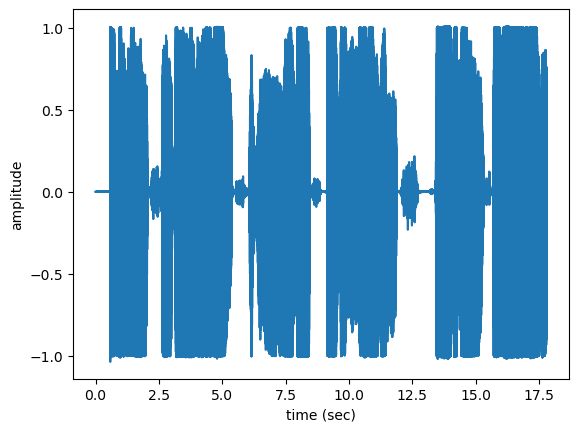

In [43]:
n = 1
# 更换下标，准备加载并可视化/播放列表里的第 2 条音频（Python 从 0 开始计数）。

x, fs = librosa.load(files[n], sr=fs)
# 重新加载波形：
#   x  – 归一化浮点数组 [-1, 1]
#   fs – 实际采样率 (Hz)；若 sr 保持 None 则默认 22 050 Hz。
# 若之前 fs 已赋值且文件同采样率，可省略 sr=fs；写上可保证一致性。
# 标准格式：librosa.load(path, sr=22050, mono=True, offset=0.0, duration=None)

t = np.arange(len(x)) / fs
# 构造时间轴 (秒)：采样点序号除以采样率。
# np.arange(N) 生成 0…N-1，形状与 x 相同，可直接广播。

plt.plot(t, x)
# 画时域波形：横轴时间，纵轴幅值。

plt.xlabel('time (sec)')
# 给横轴加标签。

plt.ylabel('amplitude')
# 给纵轴加标签。

plt.show()
# 立即渲染图像（在 Notebook 中无需阻塞，但保留好习惯）。

display(ipd.Audio(files[n]))
# 把同一条音频以 HTML5 控件形式嵌入单元格，可点击播放。
# 需提前导入：import IPython.display as ipd
# 标准格式：ipd.Audio(filename=路径) 或 ipd.Audio(data=数组, rate=fs)

In [45]:
f0, voiced_flag = getPitch_librosa(x.copy(), fs, winLen=0.02)
# 调用自定义基频提取函数，对当前波形计算 F0 与浊音标记。
# 参数说明：
#   x.copy() – 传入副本，防止函数内部对原波形做 inplace 修改（librosa.pyin 不会改输入，但养成防御习惯）。
#   fs       – 采样率，与加载时保持一致。
#   winLen=0.02 – 把窗长从默认 30 ms 改成 20 ms，可提高时间分辨率，但频率分辨率略降。
# 返回值：
#   f0          – 每帧基频 (Hz)，无语音帧为 nan；长度 = ceil(len(x)/hop)。
#   voiced_flag – bool 数组，True 表示该帧被判定为浊音。
# 标准格式：自定义函数签名 getPitch_librosa(x, fs, winLen=0.03)

Text(0.5, 0, 'frame-index')

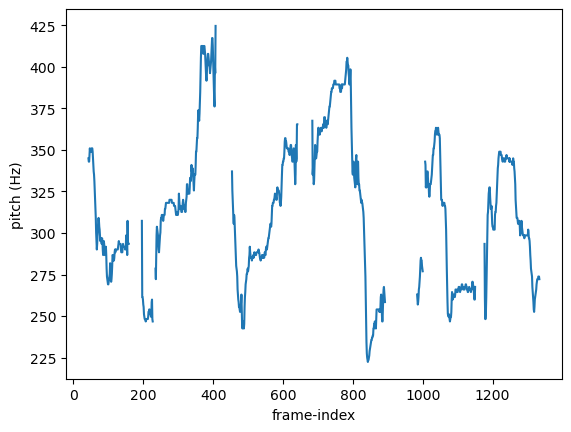

In [46]:
plt.plot(f0)
plt.ylabel('pitch (Hz)')
plt.xlabel('frame-index')

In [47]:
def getPitch_spkit(x, fs, winLen=0.02, thr=-60, f0err=3.0, window='hann'):
    # 用 spkit 提供的 f0_detection 估算基频（基于倒谱/互相关等）。
    # 参数:
    #   x      – 一维波形数组
    #   fs     – 采样率 (Hz)
    #   winLen – 期望窗长 (秒)，默认 20 ms
    #   thr    – 能量阈值 (dB)，低于此值认为无语音，函数内会强制 f0=0
    #   f0err  – 允许的最大 F0 跳变 (semitones)，用于平滑
    #   window – 窗函数名，默认 'hann'，可换 'hamming'/'blackman' 等
    # 返回:
    #   f0          – 每帧 F0 (Hz)；无语音/失败处为 nan
    #   voiced_flag – bool 数组，True 表示该帧有语音

    p = winLen * fs
    # 窗长换算成采样点数。

    frame_length = int(2 ** int(p - 1).bit_length())
    # 取 ≥ p 的最小 2 的幂，加速 FFT。

    hop_length = frame_length // 2
    # 50 % 重叠。

    f0 = sp.f0_detection(
        x, fs,
        winlen=frame_length,
        overlap=hop_length,
        f0min=80, f0max=450,
        thr=thr,
        f0err=f0err,
        window=window
    )
    # spkit 的 f0_detection 返回与帧数等长的 ndarray；
    # 无语音/能量低于 thr 的帧 F0 被置 0。

    voiced_flag = f0 != 0
    # 生成布尔掩码：True 表示该帧有有效 F0。

    if np.mean(f0 == 0) < 1:
        # 如果并非“所有帧都是 0”，才把 0 替换成 nan，方便后续统计/画图。
        f0[f0 == 0] = np.nan
    else:
        # 否则（全程无语音）直接全部设 nan，避免除零或警告。
        f0 = f0 + np.nan   # 全 0 数组 + nan -> 全 nan 数组

    return f0, voiced_flag

In [21]:
print(type(x))  # Should be <class 'numpy.ndarray'>
print(type(f0))  # Should be <class 'numpy.ndarray'>

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [50]:
f0, voiced_flag = getPitch_spkit(
    x.copy(),           # 传入波形副本，防止原数组被修改（虽然函数内并不会改写 x）
    fs,                 # 采样率，与加载时保持一致
    winLen=0.02,        # 窗长 20 ms → 时间分辨率↑，频率分辨率↓
    thr=-60,            # 能量阈值 -60 dB：低于此值视为无语音，F0 强制 0（后续再变 nan）
    f0err=3,            # 允许最大 F0 跳变 3 个半音，用于平滑
    window='blackman'   # 选用 blackman 窗，旁瓣衰减比 hann 更好，频谱泄漏更小
)
# 返回：
#   f0          – 每帧基频 (Hz)，无语音处 nan
#   voiced_flag – bool 数组，True 表示该帧有有效 F0

/home/ad269139-dfd9-4f5c-8fb3-1d1abcd4e082/.local/lib/python3.11/site-packages/spkit/core/advance_techniques.py:1258: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


Text(0.5, 0, 'frame-index')

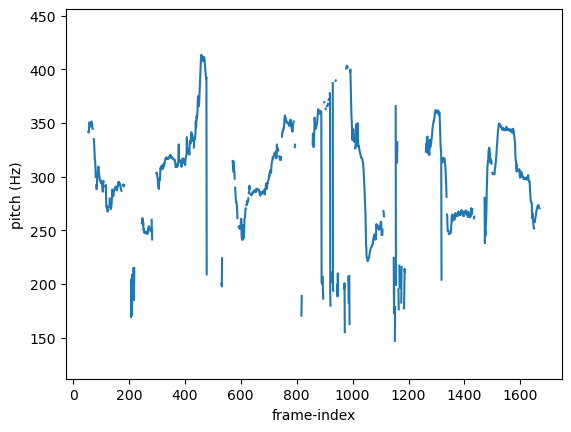

In [25]:
plt.plot(f0)
plt.ylabel('pitch (Hz)')
plt.xlabel('frame-index')

You might notice a small difference in the pitch value, becuase the implementation of each library has a small variation.

## All features together 

Let's consider the problem of identifying the type of interpretation of one of the audio recordings. Then next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and a binary label (`y`), that indicates whether the type of interpretation is a hum (`y=1`) or whistle (`y=0`).

In [51]:
def getXy(files, labels_file, scale_audio=False, onlySingleDigit=False):
    """
    遍历所有 wav 文件，提取 4 个简单特征并构造数据集。
    参数:
        files          – 文件路径列表
        labels_file    – 已建好索引的 DataFrame，索引=文件名，列含 interpretation
        scale_audio    – 是否把波形归一化到 [-1,1] 峰值
        onlySingleDigit– 预留占位，当前未使用（可扩展过滤逻辑）
    返回:
        X – ndarray (n_samples, 4)  特征矩阵
        y – ndarray (n_samples,)    二分类标签 (True=hum, False=not hum)
    """
    X, y = [], []                       # 分别存放特征向量和标签
    for file in tqdm(files):            # tqdm 显示进度条
        # ----- 1. 解析文件名 -----
        fileID = file.replace("\\", "/").split('/')[-1]
        file_name = fileID              # 保留两份，方便后续扩展

        # ----- 2. 查标签 -----
        yi = labels_file.loc[fileID]['interpretation'] == 'hum'
        # 若 interpretation 列值为 'hum' 则 yi=True，否则 False

        # ----- 3. 读音频 -----
        fs = None                       # 强制 22050 Hz
        x, fs = librosa.load(file, sr=fs)
        if scale_audio:                 # 可选峰值归一化
            x = x / np.max(np.abs(x))

        # ----- 4. 提取基频 -----
        f0, voiced_flag = getPitch_librosa(x, fs, winLen=0.02)

        # ----- 5. 计算 4 个特征 -----
        power = np.sum(x**2) / len(x)               # 平均功率
        # 若 f0 全 nan，则均值/标准差填 0，避免 RuntimeWarning
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0)) < 1 else 0
        pitch_std  = np.nanstd(f0)  if np.mean(np.isnan(f0)) < 1 else 0
        voiced_fr  = np.mean(voiced_flag)           # 浊音帧比例

        xi = [power, pitch_mean, pitch_std, voiced_fr]
        X.append(xi)
        y.append(yi)

    return np.array(X), np.array(y).astype(bool)   # 显式转 bool 数组

Let's apply `getXy` to the subsample and obtain the NumPy predictor array (`X`) and a binary label (`y`). This could take a while, as we are processing each of the 98 recordings.

In [27]:
X,y = getXy(files, labels_file=MLENDHW_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 98/98 [04:13<00:00,  2.58s/it]


The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [28]:
print('The shape of X is', X.shape)
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (98, 4)
The shape of y is (98,)
The labels vector is [False  True  True  True False False False False  True  True  True False
  True  True  True False False False False False  True  True  True  True
  True  True  True False  True False  True False  True False  True  True
  True False  True  True  True False  True False  True False  True False
  True False False False False False  True False False False  True False
  True False  True  True  True  True  True False  True False  True  True
  True False False  True  True False False  True False False False False
 False False False False False  True  True False  True  True False False
 False  True]


As you can see, we have 98 items consisting of 4 features (stored in `X`) and one binary label (stored in `y`). Is our dataset balanced? Let's have a look:

In [29]:
print(' The number of hum recordings is ', np.count_nonzero(y))
print(' The number of whistle recordings is ', y.size - np.count_nonzero(y))

 The number of hum recordings is  49
 The number of whistle recordings is  49


# Modeling: Support Vector Machines

Let's build a support vector machine (SVM) model for the predictive task of identifying the type of interpretation (hum/whistle) of an audio signal, using the dataset that we have just created.

We will use the SVM method provided by scikit-learn and will split the dataset defined by X and y into a training set and a validation set.

In [52]:
from sklearn import svm
# 导入支持向量机模块，后续可创建 svm.SVC() 或 svm.SVR() 等模型。

from sklearn.model_selection import train_test_split
# 导入数据集划分工具，可一次性完成训练集/验证集拆分，支持分层、随机种子等参数。

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,      # 30 % 样本划入验证集，70 % 为训练集
    random_state=None,  # 默认 None，每次运行结果不同；设整数可复现
    shuffle=True,       # 默认 True，先打乱再划分
    stratify=None       # 二分类可设 stratify=y 做分层抽样，保持正负比例一致
)
# 返回顺序固定：训练特征、验证特征、训练标签、验证标签
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((68, 4), (30, 4), (68,), (30,))

Can you identify the number of items in the training and validation sets?

Let's now fit an SVM model and print both the training accuracty and validation accuracy.


In [53]:
model = svm.SVC(C=1)
# 实例化一个支持向量分类器：
#   C=1 – 正则强度，值越大越不允许误分（硬间隔），默认 1。
# 默认核为 'rbf'，其余参数 gamma='scale', kernel='rbf', probability=False 等保持默认。

model.fit(X_train, y_train)
# 在训练集上求解 SVM 优化问题，得到支持向量与决策边界。
# 要求：X_train 二维数组 (n_samples, n_features)；y_train 一维数组或列表，元素需为 {0,1} 或 {False,True}。

yt_p = model.predict(X_train)
# 对训练集做预测，返回与 y_train 同长的布尔/整型数组，用于计算训练准确率。

yv_p = model.predict(X_val)
# 对验证集做预测，得到验证集预测标签。

print('Training Accuracy', np.mean(yt_p == y_train))
# 训练集准确率：预测与真实相符的比例。np.mean 对布尔数组求均值即得比例。

print('Validation Accuracy', np.mean(yv_p == y_val))
# 验证集准确率，衡量泛化性能。

print('The support vectors are', model.support_vectors_.shape)
# model.support_vectors_ – 支持向量二维数组 (n_SV, n_features)。
# .shape 可看出共找到多少个支持向量；若远小于样本数说明模型较稀疏。

Training Accuracy 0.9411764705882353
Validation Accuracy 0.9666666666666667
The support vectors are (26, 4)


Compare the training and validation accuracies. Is our model overfitting, underfitting, performing well? What do you think the accuracy of a random classifier would be?

Let's normalise the predictors, to see if the performance improves.


In [54]:
# ---- 1. 计算训练集各特征的均值 & 标准差 ----
mean = X_train.mean(0)      # 按列求均值，返回形状 (n_features,)
sd   = X_train.std(0)       # 按列求标准差，返回形状 (n_features,)

# ---- 2. 同分布标准化（Z-score） ----
# 用训练集统计量对训练/验证集都做变换，防止数据泄漏
X_train = (X_train - mean) / sd
X_val   = (X_val - mean) / sd
# 标准化后各特征大致服从 N(0,1)，SVM 收敛更快、数值更稳。

# ---- 3. 重新训练 SVM（带自定义 gamma） ----
model = svm.SVC(C=1, gamma=2)   # gamma=2 比默认 'scale' 更高，决策边界更弯曲
model.fit(X_train, y_train)     # 必须在标准化后的数据上重新 fit

# ---- 4. 预测 ----
yt_p = model.predict(X_train)   # 训练集预测
yv_p = model.predict(X_val)     # 验证集预测

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 1.0
Validation  Accuracy 1.0
The support vectors are (49, 4)


What machine learning pipeline have we implemented for each solution? Feel free to try other machine learning models available in scikit, it's extremely easy!